# Import des librairies

In [1]:
#Main libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Embeddings

from sentence_transformers import util, SentenceTransformer

In [3]:
#deep learning

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau

In [4]:
#Classifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [5]:
#Model selection

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from IPython.display import display

# Import des données

In [6]:
data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [7]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
data.shape

(7613, 5)

In [9]:
data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Split training data and validation data

In [10]:
train_data, val_data = train_test_split(data, test_size=0.1)

In [11]:
train_data.shape

(6851, 5)

In [12]:
val_data.shape

(762, 5)

### Resetting index

In [13]:
train_data.reset_index(drop=True, inplace=True)

In [14]:
train_data.head()

,id,keyword,location,text,target
0,10810,wrecked,6,@Tunes_WGG lol. U got wrecked,0
1,313,annihilated,NaN,Cop pulls drunk driver to safety SECONDS befor...,1
2,1607,bombed,MY RTs ARE NOT ENDORSEMENTS,@ChristophersZen @HunterLove1995 @tblack yeah ...,0
3,589,arson,NaN,Tennessee lesbian couple faked hate crime and ...,1
4,3900,devastated,PG Chillin!,Man Currensy really be talkin that talk... I'd...,1


In [15]:
val_data.reset_index(drop=True, inplace=True)

### Separating X and target

In [16]:
X_train = train_data['text']

In [17]:
y_train = train_data['target']

In [18]:
X_val = val_data['text']

In [19]:
y_val = val_data['target']

# Data Engineering

In [20]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
data.keyword.isna().sum()

61

In [22]:
data.location.isna().sum()

2533

In [23]:
l_full_text = []

for i in range(data.shape[0]):
    full_text = data['text'][i]
    if str(data['keyword'][i]) != 'nan':
        full_text += f' #{data["keyword"][i]}'
    if str(data['location'][i]) != 'nan':
        full_text += f' #{data["location"][i]}'

    l_full_text.append(full_text)

In [24]:
data['full_text'] = pd.Series(l_full_text)

In [25]:
data.head()

,id,keyword,location,text,target,full_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


Après quelques essais, les embeddings de full_text offrent de moins bons résultats de prédiction que ceux du texte simple.

# Sentence Embeddings

In [26]:
transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [27]:
embeddings = transformer.encode(X_train)

In [28]:
embeddings.shape

(6851, 768)

In [29]:
val_embeddings = transformer.encode(X_val)

# Deep Learning Model

### Convert embeddings and target to tensors

In [30]:
tensor_embeddings = tf.convert_to_tensor(embeddings)
tensor_y = tf.convert_to_tensor(y_train)

Metal device set to: Apple M1


2022-08-29 17:44:19.563600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-29 17:44:19.563717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [31]:
tensor_embeddings.shape

TensorShape([6851, 768])

In [32]:
tensor_y.shape

TensorShape([6851])

In [33]:
tensor_val_embeddings = tf.convert_to_tensor(val_embeddings)
tensor_val_y = tf.convert_to_tensor(y_val)

### Define model architecture

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [35]:
optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

In [36]:
model = Sequential()

# Define model architecture.
model.add(Dense(728, input_shape=(768,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 728)               559832    
                                                                 
 dropout (Dropout)           (None, 728)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               186624    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [38]:
model.compile(
    optimizer=optimizer, #or optimizer
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

### Training and performances visualization

In [39]:
history = model.fit(
    x=tensor_embeddings,
    y=tensor_y,
    validation_data=(tensor_val_embeddings, tensor_val_y),
    callbacks=[learning_rate_reduction],
    epochs = 20)

Epoch 1/20


2022-08-29 17:44:19.698334: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-29 17:44:19.896703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 8ms/step - loss: 0.4461 - accuracy: 0.8062 - val_loss: 0.4457 - val_accuracy: 0.8084 - lr: 0.0010
Epoch 2/20
  1/215 [..............................] - ETA: 2s - loss: 0.2819 - accuracy: 0.8750

2022-08-29 17:44:21.752529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 2s 8ms/step - loss: 0.3811 - accuracy: 0.8419 - val_loss: 0.4610 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 2s 9ms/step - loss: 0.3366 - accuracy: 0.8577 - val_loss: 0.4710 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2954 - accuracy: 0.8758 - val_loss: 0.5309 - val_accuracy: 0.8176 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 2s 8ms/step - loss: 0.2411 - accuracy: 0.8987 - val_loss: 0.6535 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 6/20
211/215 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9196
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 2s 8ms/step - loss: 0.1927 - accuracy: 0.9199 - val_loss: 0.6325 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 7/20
215/215 [==============================] - 2s 8ms/step - loss: 0

In [40]:
def plot_training_results(history, model_name):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    
    epochs_nb = history.params['epochs']
    
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.set_title(f'Loss history of {model_name} over {epochs_nb} epochs')
    ax_loss.set_xlabel('Number of epochs')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    
    ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
    ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax_acc.set_title(f'Accuracy history of {model_name} over {epochs_nb} epochs')
    ax_acc.set_xlabel('Number of epochs')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.legend()

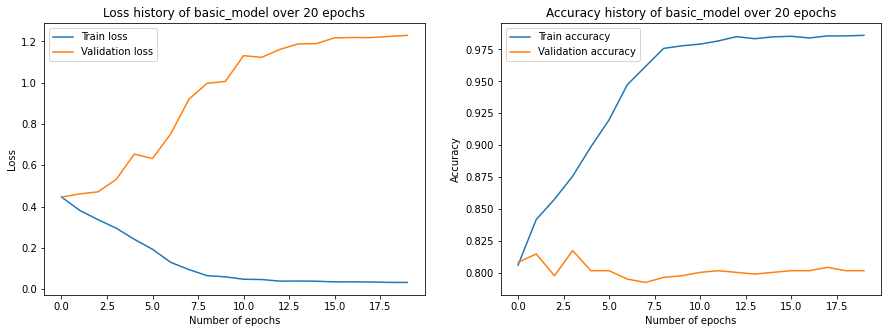

In [41]:
plot_training_results(history, 'basic_model')

# Classifier approaches 

### RandomForestClassifier

In [42]:
rfc = RandomForestClassifier(verbose=1)

In [43]:
rfc.fit(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished


RandomForestClassifier(verbose=1)

In [44]:
rfc.score(embeddings, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


0.997372646329003

In [45]:
rfc.score(val_embeddings, y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.7965879265091863

### GradientBoostingClassifier

In [46]:
gbc = GradientBoostingClassifier(verbose=1)

In [47]:
gbc.fit(embeddings, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3189            1.74m
         2           1.2801            1.72m
         3           1.2448            1.70m
         4           1.2127            1.68m
         5           1.1824            1.67m
         6           1.1562            1.65m
         7           1.1316            1.63m
         8           1.1093            1.61m
         9           1.0884            1.59m
        10           1.0700            1.58m
        20           0.9328            1.40m
        30           0.8509            1.24m
        40           0.7958            1.07m
        50           0.7534           53.57s
        60           0.7201           43.05s
        70           0.6917           32.39s
        80           0.6678           21.76s
        90           0.6485           10.93s
       100           0.6313            0.00s


GradientBoostingClassifier(verbose=1)

In [48]:
gbc.score(embeddings, y_train)

0.8766603415559773

In [49]:
gbc.score(val_embeddings, y_val)

0.8175853018372703

# Hyperparameters tuning

In [50]:
param_grid = { 'n_estimators': [100, 300, 500, 1000],
               'max_depth': [300, 500, 1000]
              }

### RandomForestClassifier

In [ ]:
grid = GridSearchCV(RandomForestClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   8.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.8s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.9s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=100; total time=   7.7s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.5s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.2s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  22.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  22.9s


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   23.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=300; total time=  23.2s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.9s


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ....................max_depth=300, n_estimators=500; total time=  38.8s


In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

### GradientBoostingClassifier

Due to the time of computing needed to run GridSearchCV on GradientBoostingClassifier with our param_grid, we are going to use HalvingGridSearchCV.

In [ ]:
grid = HalvingGridSearchCV(GradientBoostingClassifier(verbose=1), param_grid, verbose=2)

grid.fit(embeddings, y_train)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_.score(val_embeddings, y_val)

# Fine-Tuning BertForSequenceClassification

In [ ]:
from transformers import TFBertForSequenceClassification
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')